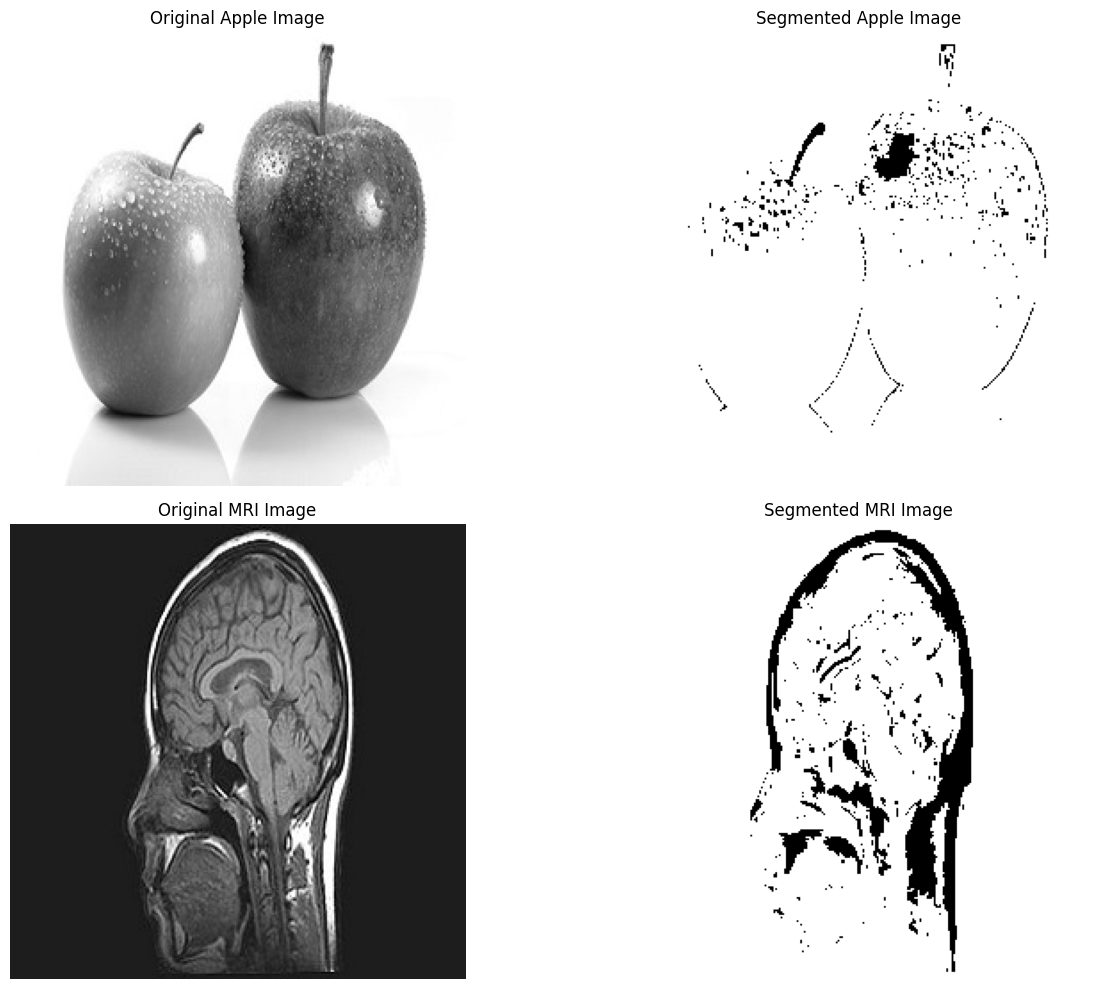

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

apple_image_path = "apple.jpg"
mri_image_path = "mri.jpg"


def region_growing(img, seed):
    height, width = img.shape
    visited = np.zeros_like(img, dtype=np.uint8)
    output = np.zeros_like(img, dtype=np.uint8)
    threshold = 20
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    stack = [seed]

    while stack:
        x, y = stack.pop()

        if visited[y, x] == 1:
            continue

        visited[y, x] = 1
        output[y, x] = 255

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height:
                diff = abs(int(img[y, x]) - int(img[ny, nx]))
                if diff < threshold and visited[ny, nx] == 0:
                    stack.append((nx, ny))

    return output


apple_img = cv2.imread(apple_image_path, cv2.IMREAD_GRAYSCALE)
seed_apple = (apple_img.shape[1] // 2, apple_img.shape[0] // 2)
segmented_apple = region_growing(apple_img, seed_apple)


mri_img = cv2.imread(mri_image_path, cv2.IMREAD_GRAYSCALE)
seed_mri = (mri_img.shape[1] // 2, mri_img.shape[0] // 2)
segmented_mri = region_growing(mri_img, seed_mri)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].imshow(apple_img, cmap='gray')
axes[0, 0].set_title('Original Apple Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(segmented_apple, cmap='gray')
axes[0, 1].set_title('Segmented Apple Image')
axes[0, 1].axis('off')

axes[1, 0].imshow(mri_img, cmap='gray')
axes[1, 0].set_title('Original MRI Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(segmented_mri, cmap='gray')
axes[1, 1].set_title('Segmented MRI Image')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

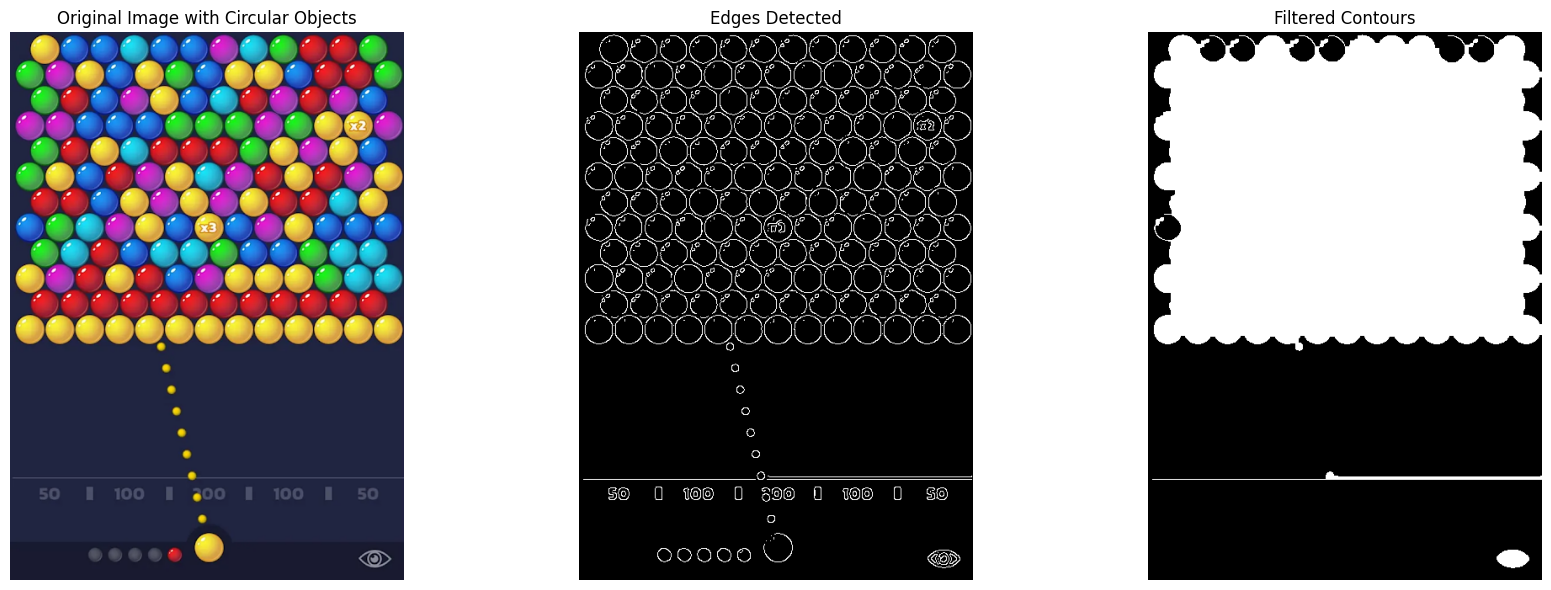

In [ ]:
kmeans_image_path = 'practica2.1_kmeans_2.png'

kmeans_example_img = cv2.imread(kmeans_image_path, cv2.IMREAD_COLOR)
kmeans_example_img_gray = cv2.cvtColor(kmeans_example_img, cv2.COLOR_BGR2GRAY)


def filtro_canny(imagen, umbral_bajo=50, umbral_alto=400):
    # Cargar la imagen

    # Aplicar el filtro Gaussiano para reducir el ruido
    imagen_suavizada = cv2.GaussianBlur(imagen, (5, 5), 1.4)

    # Calcular los gradientes utilizando los kernels de Sobel
    Ix = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular la magnitud y el ángulo del gradiente
    magnitud_gradiente = np.sqrt(Ix**2 + Iy**2)
    angulo_gradiente = np.arctan2(Iy, Ix)

    # Supresión no máxima
    imagen_suprimida = np.zeros_like(magnitud_gradiente)
    angulo_gradiente = angulo_gradiente * 180.0 / np.pi
    angulo_gradiente[angulo_gradiente < 0] += 180

    for i in range(1, imagen.shape[0] - 1):
        for j in range(1, imagen.shape[1] - 1):
            angulo = angulo_gradiente[i, j]
            if (0 <= angulo < 22.5) or (157.5 <= angulo <= 180):
                vecinos = [magnitud_gradiente[i, j - 1], magnitud_gradiente[i, j + 1]]
            elif 22.5 <= angulo < 67.5:
                vecinos = [magnitud_gradiente[i - 1, j - 1], magnitud_gradiente[i + 1, j + 1]]
            elif 67.5 <= angulo < 112.5:
                vecinos = [magnitud_gradiente[i - 1, j], magnitud_gradiente[i + 1, j]]
            else:
                vecinos = [magnitud_gradiente[i - 1, j + 1], magnitud_gradiente[i + 1, j - 1]]

            if magnitud_gradiente[i, j] >= max(vecinos):
                imagen_suprimida[i, j] = magnitud_gradiente[i, j]

    # Doble umbral
    imagen_umbral = np.zeros_like(imagen_suprimida)
    imagen_umbral[(imagen_suprimida >= umbral_bajo) & (imagen_suprimida <= umbral_alto)] = 255

    return imagen_umbral




edges = filtro_canny(kmeans_example_img_gray)

kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

closing = cv2.convertScaleAbs(closing)
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 500
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

contour_img = np.zeros_like(kmeans_example_img_gray)
cv2.drawContours(contour_img, filtered_contours, -1, (255), thickness=-1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(kmeans_example_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image with Circular Objects')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges Detected')
axes[1].axis('off')

axes[2].imshow(contour_img, cmap='gray')
axes[2].set_title('Filtered Contours')
axes[2].axis('off')

plt.tight_layout()
plt.show()
